Q: For exposure time calculations, should we be using the (bright sky)/(nominal dark sky) ratio derived at 5000A (b spectrograph) or 6500A (r spectrograph)? 

In this notebook, I'll measure this sky ratio at 5000A and 6500A for the CMX sky data

## updates
- **06/08/2020** sky ratios at more wavelengths and broader smoothing to erase out some of the features

In [1]:
import h5py
import numpy as np 
from scipy.signal import medfilt
from scipy.signal import medfilt2d
# -- astropy --
import astropy.units as u
# -- desihub --
import desisim.simexp
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['medfilt2dtex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# read nominal dark sky surface brightness
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

In [4]:
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

In [5]:
# read sky surface brightnesses for CMX BGS exposures
fskies = h5py.File('/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/sky_fibers.cmx.v1.hdf5', 'r')
skies = {}
for k in fskies.keys():
    skies[k] = fskies[k][...]
fskies.close()

In [6]:
iexp = 0
for k in skies.keys():
    if 'wave' not in k and 'sky_sb' not in k: 
        print(k, skies[k][iexp])

airmass 1.1512601841536443
date 20200303
expid 52932
exptime 500.0
fwhm 1.1716717565059662
mjd 58912.279591935
moon_alt 35.75992627444927
moon_ill 0.6481420836060378
moon_sep 35.1272638811806
spectrograph 6
sun_alt -61.199755271549535
sun_sep 121.91097816773487
tileid 70500
transp_max 0.9791855265784067
transp_min 0.8751343888393194
transparency 0.9304259523400431


(0.0, 10)

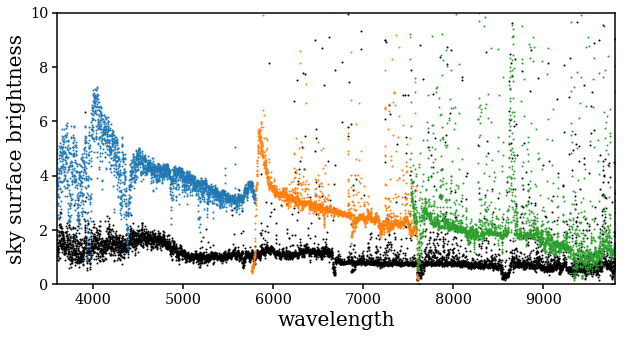

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(wave, nominal_surface_brightness_dict['dark'], c='k', s=1)
for band in ['b', 'r', 'z']: 
    sub.scatter(skies['wave_%s' % band], skies['sky_sb_%s' % band][iexp], s=1)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness', fontsize=20)
sub.set_ylim(0., 10)

In [8]:
smooth_skies_b = medfilt2d(skies['sky_sb_b'], (1, 501))
smooth_skies_r = medfilt2d(skies['sky_sb_r'], (1, 501))

(0.0, 10)

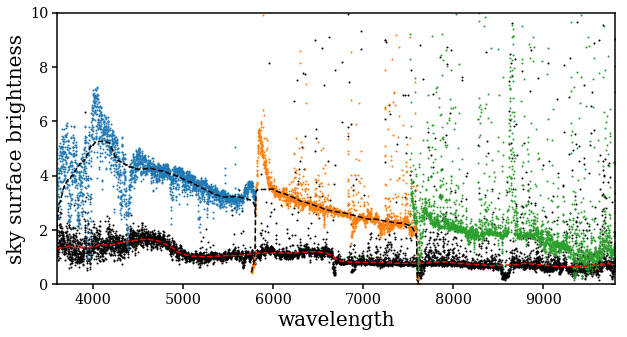

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(wave, nominal_surface_brightness_dict['dark'], c='k', s=1)
sub.plot(wave, medfilt(nominal_surface_brightness_dict['dark'], 501), c='r', ls='--')
for band in ['b', 'r', 'z']: 
    sub.scatter(skies['wave_%s' % band], skies['sky_sb_%s' % band][iexp], s=1)
    
sub.plot(skies['wave_b'], smooth_skies_b[iexp], c='k', ls='--')
sub.plot(skies['wave_r'], smooth_skies_r[iexp], c='k', ls='--')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness', fontsize=20)
sub.set_ylim(0., 10)

In [10]:
waves = [4000, 5000, 6000, 7000]
sky_ratios = [] 
for w in waves: 
    if w < skies['wave_b'].max():    
        _wave = skies['wave_b']
        _smooth_skies = smooth_skies_b
    elif w < skies['wave_r'].max(): 
        _wave = skies['wave_r']
        _smooth_skies = smooth_skies_r
    else:
        raise ValueError
            
    nom_near_wave = np.median(medfilt(nominal_surface_brightness_dict['dark'], 501)[(wave.value > w-5.) & (wave.value < w+5.)])

    near_wave = (_wave > w-5.) & (_wave < w+5.)
    sky_ratio = np.median(_smooth_skies[:, near_wave], axis=1) / nom_near_wave
    sky_ratios.append(sky_ratio)

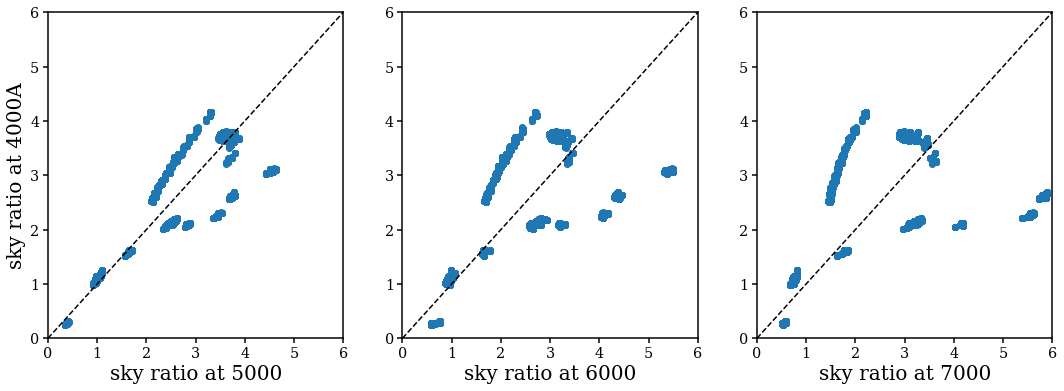

In [11]:
fig = plt.figure(figsize=(18,6))
for i in range(3): 
    sub = fig.add_subplot(1,3,i+1)
    sub.scatter(sky_ratios[i+1], sky_ratios[0])
    sub.plot([0., 6.], [0., 6.], c='k', ls='--')
    sub.set_xlabel('sky ratio at %i' % waves[i+1], fontsize=20)
    sub.set_xlim(0., 6)
    if i == 0: sub.set_ylabel('sky ratio at %iA' % waves[0], fontsize=20)
    sub.set_ylim(0., 6)

(0.0, 6)

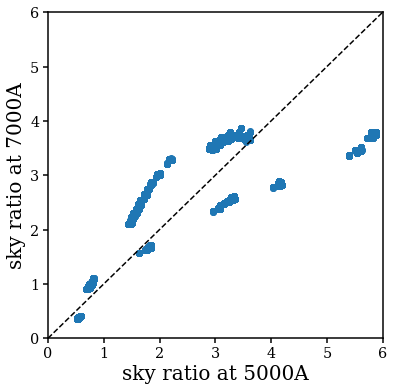

In [12]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(sky_ratios[3], sky_ratios[1])
sub.plot([0., 6.], [0., 6.], c='k', ls='--')
sub.set_xlabel('sky ratio at %iA' % waves[1], fontsize=20)
sub.set_xlim(0., 6)
sub.set_ylabel('sky ratio at %iA' % waves[3], fontsize=20)
sub.set_ylim(0., 6)

In [13]:
fskies = h5py.File('/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/sky_fibers.cmx.v1.hdf5', 'a')
for w, _sky_ratio in zip(waves, sky_ratios): 
    fskies.create_dataset('sky_ratio_%i' % int(w), data=_sky_ratio)
fskies.close()